## This notebook reproduce a solver error which can be resolved by increasing rtol or make the cycling condition milder

### the error is induced by having low porosity, and high LiP parameter, even it doesn't induce lots of LLI to LiP

### directly calculate, fail;
### set_initial_conditions_from, pass!
### also relate to rtol of the solver! reduce that can make some failing cases pass!

In [454]:
#import os
import matplotlib.pyplot as plt
import numpy as np
import pybamm
import pandas as pd
import timeit
start = timeit.default_timer()
#os.chdir(pybamm.__path__[0]+'/..')
# pybamm.set_logging_level("INFO")

In [455]:
model = pybamm.lithium_ion.DFN(
    options={
        #"particle": "Fickian diffusion", 
        "SEI": "solvent-diffusion limited",
        #"SEI on cracks": "true",
        "SEI film resistance": "distributed", 
        "SEI porosity change": "true",
        #"particle mechanics": ("swelling and cracking", "swelling only"),
        #"loss of active material": "stress-driven",
        "lithium plating": "partially reversible"   # partially
    }
)

In [456]:
param = pybamm.ParameterValues("OKane2022")
# ParameterValues(Para_dict_used["Para_Set"]  )
param.update({"Upper voltage cut-off [V]": 4.21})
param.update({"Lower voltage cut-off [V]": 2.49})
#
param.update(
    {"EC initial concentration in electrolyte [mol.m-3]": 
     4541})
param.update(
    {"Inner SEI lithium interstitial diffusivity [m2.s-1]": 
     1e-20	})  
param.update(
    {"Negative electrode porosity": 0.15	})  
param.update(
    {"Outer SEI solvent diffusivity [m2.s-1]": 
     3e-20	})  
param.update(
    {"Dead lithium decay constant [s-1]": 
     4E-6	})  
param.update(
    {"Lithium plating kinetic rate constant [m.s-1]": 
    1E-6}) # 1e-8 works   


In [457]:
total_cycles=8
exp = pybamm.Experiment(
    [
        "Hold at 4.2V until C/100", 
        "Rest for 4 hours (5 minute period)", 
        "Discharge at C/10 until 2.5V (5 minute period)", 
        "Charge at 0.3C until 4.2V (5 minute period)", 
        "Hold at 4.2V until C/100 (5 minute period)"]  
        + [(
        "Discharge at 1C until 2.5V", 
        "Charge at 0.3C until 4.2V (5 minute period)", 
        "Hold at 4.2V until C/100 (5 minute period)",
        ),] * total_cycles 
        + [(
        "Discharge at 1C until 2.56V", # until 2.55V fail!
        #      until 2.58V works!   for 66 minutes works!
        # or change rtol=1e-7 for 2.56V
        #"Charge at 0.3C until 3.8V", #  (5 minute period) 
        #"Hold at 4.2V until C/100 (5 minute period)",
        ),] 
)
# """


### in the above example, we find that if we do:
#### (1) "Discharge at 1C until 2.58V" or
#### (2) "Discharge at 1C for 66 minutes"
### the model will work with rtol=1e-6 (default)
### however, if we do:
#### (3)  "Discharge at 1C until 2.56V" with rtol=1e-6, it will fail
The linesearch algorithm failed with too small a step.
2023-08-27 22:03:30.433 - [ERROR] callbacks.on_experiment_error(224): Simulation error: Error in Function::call for 'F' [IdasInterface] at .../casadi/core/function.cpp:1401:
Error in Function::call for 'F' [IdasInterface] at .../casadi/core/function.cpp:330:
.../casadi/interfaces/sundials/idas_interface.cpp:596: IDACalcIC returned "IDA_LINESEARCH_FAIL". Consult IDAS documentation.
### unless we change rtol=1e-7
### therefore, it seems related to the solver 

In [458]:
var_pts = {
    "x_n": 5,  # negative electrode
    "x_s": 5,  # separator 
    "x_p": 5,  # positive electrode
    "r_n": 60,  # negative particle
    "r_p": 30,  # positive particle
}

solver=pybamm.CasadiSolver(return_solution_if_failed_early=True)
solver.max_step_decrease_count
#print(current_reltol)

In [466]:
sim1 = pybamm.Simulation(
    model, 
    experiment=exp,
    parameter_values=param,
    solver=pybamm.CasadiSolver(
        return_solution_if_failed_early=True,
        #max_step_decrease_count=10,
        rtol=1e-6,
        ),
    var_pts=var_pts,
)
solution1 = sim1.solve(calc_esoh=False)
stop = timeit.default_timer()
print('running time: ' + str(stop - start) +'s')

The linesearch algorithm failed with too small a step.
2023-08-27 22:03:30.433 - [ERROR] callbacks.on_experiment_error(224): Simulation error: Error in Function::call for 'F' [IdasInterface] at .../casadi/core/function.cpp:1401:
Error in Function::call for 'F' [IdasInterface] at .../casadi/core/function.cpp:330:
.../casadi/interfaces/sundials/idas_interface.cpp:596: IDACalcIC returned "IDA_LINESEARCH_FAIL". Consult IDAS documentation.


running time: 661.5777826000121s


exp_2 = pybamm.Experiment([( 
    "Discharge at 1C until 2.5V", 
    "Charge at 0.3C until 4.2V", #  (5 minute period) 
    "Hold at 4.2V until C/100 (5 minute period)",
    ),] )
model_2 = model.set_initial_conditions_from(solution1, inplace=True)
sim2 = pybamm.Simulation(
    model_2, 
    experiment=exp_2,
    parameter_values=param,
    solver=pybamm.CasadiSolver(return_solution_if_failed_early=True),
    var_pts=var_pts,
)
sol2 = sim2.solve(calc_esoh=False)

3


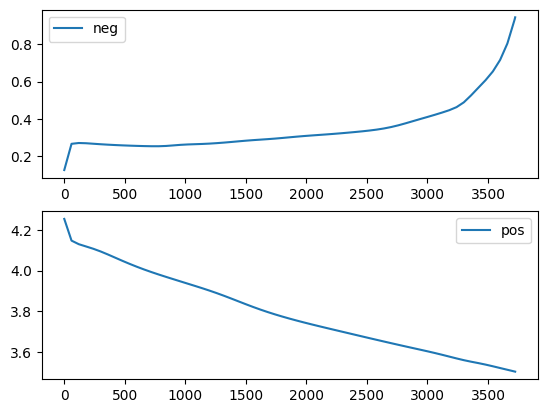

In [460]:
mesh_sep = len(solution1.cycles[-1]["Separator electrolyte potential [V]"].entries[:,0])
if mesh_sep % 2 ==0:
    phi_ref = (
        solution1.cycles[-1]["Separator electrolyte potential [V]"].entries[mesh_sep//2-1,:]
        +
        solution1.cycles[-1]["Separator electrolyte potential [V]"].entries[mesh_sep//2+1,:]
        ) / 2
    print(mesh_sep/2+0.5)
else:
    phi_ref = solution1.cycles[-1]["Separator electrolyte potential [V]"].entries[mesh_sep//2,:]
    print(mesh_sep//2+1)
V =  solution1.cycles[-1]["Terminal voltage [V]"].entries
V_n = -phi_ref                     # negative tab is 0 V
V_p = V - phi_ref                 # V = V_p - V_n
time = solution1.cycles[-1]["Time [s]"].entries
time = time - time[0]
fig, ax = plt.subplots(2,1)
ax[0].plot(time,V_n,label="neg")
ax[1].plot(time,V_p,label="pos")
ax[0].legend();ax[1].legend()

In [461]:
# Quick plot
#label = ["Diff_Li_SEI = 1e-18","Diff_Li_SEI = 1e-16"] 
Vars = [
    "Negative electrode porosity",
    "Lithium plating thickness [m]",
    'Negative electrode stoichiometry',
    'Positive electrode stoichiometry',
    "Loss of capacity to lithium plating [A.h]",
    "Loss of capacity to dead lithium plating [A.h]",
    "Terminal voltage [V]",
    'Local ECM resistance [Ohm]',
]
quick_plot = pybamm.QuickPlot(solution1.cycles[-1], Vars,variable_limits='fixed') #     
quick_plot.dynamic_plot();

interactive(children=(FloatSlider(value=63.61655268630466, description='t', max=64.65111125152522, min=63.6165…

In [ ]:
5/1e4*days

In [462]:
import os
path = os.path.expanduser(
   "~/EnvPBGEM_Linux/SimSave/HPC_Paper/Repdocue_Simon")

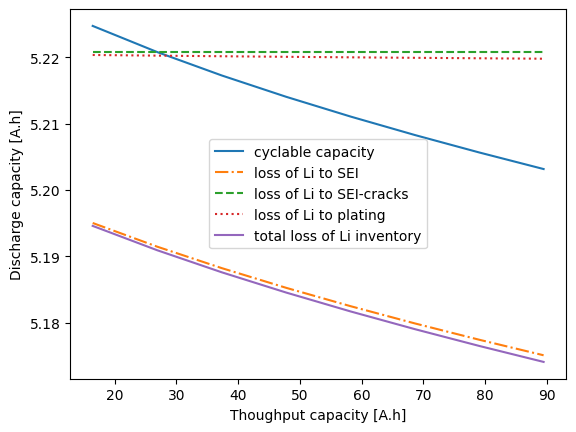

In [463]:
Q_previous = []
Q0 = solution1.cycles[0]["Discharge capacity [A.h]"].entries
Q0_delta = np.absolute(Q0[-1]-Q0[0])
Q2 = solution1.cycles[2]["Discharge capacity [A.h]"].entries
Q2_delta = np.absolute(Q2[-1]-Q2[0])
Q3 = solution1.cycles[3]["Discharge capacity [A.h]"].entries
Q3_delta = np.absolute(Q3[-1]-Q3[0])
Q4 = solution1.cycles[4]["Discharge capacity [A.h]"].entries
Q4_delta = np.absolute(Q4[-1]-Q4[0])
Q_previous.append(Q0_delta+Q2_delta+Q3_delta+Q4_delta)
Q_throughput = []
Qdis_cycles = []
Qsei = []
Qsei_cracks = []
Q_plating = []
Q_LLI = []
roughness_avg = []
roughness_sep = []
roughness_CC = []
porosity_avg = []
porosity_sep = []
porosity_CC = []
cs_neg_avg = []
cs_neg_sep = []
cs_neg_CC = []
cs_pos_avg = []
cs_pos_sep = []
cs_pos_CC = []
U_neg_avg = []
U_neg_sep = []
U_neg_CC = []
U_pos_avg = []
U_pos_sep = []
U_pos_CC = []
eta_SEI_avg = []
eta_SEI_sep = []
eta_SEI_CC = []
Lsei_avg = []
Lsei_sep = []
Lsei_CC = []
Lsei_cracks_avg = []
Lsei_cracks_sep = []
Lsei_cracks_CC = []
c_plat_avg = []
c_plat_sep = []
c_plat_CC = []
c_dead_avg = []
c_dead_sep = []
c_dead_CC = []
AM_neg_avg = []
AM_neg_sep = []
AM_neg_CC = []
AM_pos_avg = []
AM_pos_sep = []
AM_pos_CC = []
for i in range(total_cycles):
    Qdis = solution1.cycles[i+5].steps[0]["Discharge capacity [A.h]"].entries
    Qdis_delta = Qdis[-1] - Qdis[0]
    Qdis_cycles.append(Qdis_delta)
    Q_throughput.append(Q_previous[i]+Qdis_delta)
    Q_CC = solution1.cycles[i+5].steps[1]["Discharge capacity [A.h]"].entries
    Q_CC_delta = np.absolute(Q_CC[-1]-Q_CC[0])
    Q_CV = solution1.cycles[i+5].steps[2]["Discharge capacity [A.h]"].entries
    Q_CV_delta = np.absolute(Q_CV[-1]-Q_CV[0])
    Q_previous.append(Q_previous[i]+Qdis_delta+Q_CC_delta+Q_CV_delta)
    Qsei_loc=solution1.cycles[i+5].steps[0]["Loss of lithium to SEI [mol]"].entries
    Qsei.append(Qsei_loc[-1] * 96485.3/3600)  #[Ah]
    Qsei_cracks_loc=solution1.cycles[i+5].steps[0]["Loss of lithium to SEI on cracks [mol]"].entries
    Qsei_cracks.append(Qsei_cracks_loc[-1] * 96485.3/3600)  #[Ah]
    Q_pl_loc=solution1.cycles[i+5].steps[0]["Loss of lithium to lithium plating [mol]"].entries
    Q_plating.append(Q_pl_loc[-1] * 96485.3/3600)  #[Ah]
    Q_LLI.append((Qsei_loc[-1]+Qsei_cracks_loc[-1]+Q_pl_loc[-1]) * 96485.3/3600)  #[Ah]
    roughness_avg_temp = solution1.cycles[i+5].steps[0]["X-averaged negative electrode roughness ratio"].entries
    roughness_avg.append(roughness_avg_temp[-1])
    roughness_sep_temp = solution1.cycles[i+5].steps[0]["Negative electrode roughness ratio"].entries[-1,-1]
    roughness_sep.append(roughness_sep_temp)
    roughness_CC_temp = solution1.cycles[i+5].steps[0]["Negative electrode roughness ratio"].entries[0,-1]
    roughness_CC.append(roughness_CC_temp)
    poro_avg_temp = solution1.cycles[i+5].steps[0]["X-averaged negative electrode porosity"].entries
    porosity_avg.append(poro_avg_temp[-1])
    poro_sep_temp = solution1.cycles[i+5].steps[0]["Negative electrode porosity"].entries[-1,-1]
    porosity_sep.append(poro_sep_temp)
    poro_CC_temp = solution1.cycles[i+5].steps[0]["Negative electrode porosity"].entries[0,-1]
    porosity_CC.append(poro_CC_temp)
    cs_neg_avg_temp = solution1.cycles[i+5].steps[0]["X-averaged negative particle surface concentration"].entries
    cs_neg_avg.append(cs_neg_avg_temp[-1])
    cs_neg_sep_temp = solution1.cycles[i+5].steps[0]["Negative particle surface concentration"].entries[-1,-1]
    cs_neg_sep.append(cs_neg_sep_temp)
    cs_neg_CC_temp = solution1.cycles[i+5].steps[0]["Negative particle surface concentration"].entries[0,-1]
    cs_neg_CC.append(cs_neg_CC_temp)
    cs_pos_avg_temp = solution1.cycles[i+5].steps[0]["X-averaged positive particle surface concentration"].entries
    cs_pos_avg.append(cs_pos_avg_temp[-1])
    cs_pos_sep_temp = solution1.cycles[i+5].steps[0]["Positive particle surface concentration"].entries[0,-1]
    cs_pos_sep.append(cs_pos_sep_temp)
    cs_pos_CC_temp = solution1.cycles[i+5].steps[0]["Positive particle surface concentration"].entries[-1,-1]
    cs_pos_CC.append(cs_pos_CC_temp)
    U_neg_avg_temp = solution1.cycles[i+5].steps[0]["X-averaged negative electrode open-circuit potential [V]"].entries
    U_neg_avg.append(U_neg_avg_temp[-1])
    U_neg_sep_temp = solution1.cycles[i+5].steps[0]["Negative electrode open-circuit potential [V]"].entries[-1,-1]
    U_neg_sep.append(U_neg_sep_temp)
    U_neg_CC_temp = solution1.cycles[i+5].steps[0]["Negative electrode open-circuit potential [V]"].entries[0,-1]
    U_neg_CC.append(U_neg_CC_temp)
    U_pos_avg_temp = solution1.cycles[i+5].steps[0]["X-averaged positive electrode open-circuit potential [V]"].entries
    U_pos_avg.append(U_pos_avg_temp[-1])
    U_pos_sep_temp = solution1.cycles[i+5].steps[0]["Positive electrode open-circuit potential [V]"].entries[0,-1]
    U_pos_sep.append(U_pos_sep_temp)
    U_pos_CC_temp = solution1.cycles[i+5].steps[0]["Positive electrode open-circuit potential [V]"].entries[-1,-1]
    U_pos_CC.append(U_pos_CC_temp)
    eta_SEI_temp = solution1.cycles[i+5].steps[0]["X-averaged SEI film overpotential [V]"].entries
    eta_SEI_avg.append(eta_SEI_temp[-1])
    eta_SEI_sep_temp = solution1.cycles[i+5].steps[0]["SEI film overpotential [V]"].entries[-1,-1]
    eta_SEI_sep.append(eta_SEI_sep_temp)
    eta_SEI_CC_temp = solution1.cycles[i+5].steps[0]["SEI film overpotential [V]"].entries[0,-1]
    eta_SEI_CC.append(eta_SEI_CC_temp)
    Lsei_temp = solution1.cycles[i+5].steps[0]["X-averaged total SEI thickness [m]"].entries
    Lsei_avg.append(Lsei_temp[-1])
    Lsei_sep_temp = solution1.cycles[i+5].steps[0]["Total SEI thickness [m]"].entries[-1,-1]
    Lsei_sep.append(Lsei_sep_temp)
    Lsei_CC_temp = solution1.cycles[i+5].steps[0]["Total SEI thickness [m]"].entries[0,-1]
    Lsei_CC.append(Lsei_CC_temp)
    Lcr_temp = solution1.cycles[i+5].steps[0]["X-averaged total SEI on cracks thickness [m]"].entries
    Lsei_cracks_avg.append(Lcr_temp[-1])
    Lcr_sep_temp = solution1.cycles[i+5].steps[0]["Total SEI on cracks thickness [m]"].entries[-1,-1]
    Lsei_cracks_sep.append(Lcr_sep_temp)
    Lcr_CC_temp = solution1.cycles[i+5].steps[0]["Total SEI on cracks thickness [m]"].entries[0,-1]
    Lsei_cracks_CC.append(Lcr_CC_temp)
    c_plat_avg_temp = solution1.cycles[i+5].steps[0]["X-averaged lithium plating concentration [mol.m-3]"].entries
    c_plat_avg.append(c_plat_avg_temp[-1])
    c_plat_sep_temp = solution1.cycles[i+5].steps[0]["Lithium plating concentration [mol.m-3]"].entries[-1,-1]
    c_plat_sep.append(c_plat_sep_temp)
    c_plat_CC_temp = solution1.cycles[i+5].steps[0]["Lithium plating concentration [mol.m-3]"].entries[0,-1]
    c_plat_CC.append(c_plat_CC_temp)
    c_dead_avg_temp = solution1.cycles[i+5].steps[0]["X-averaged dead lithium concentration [mol.m-3]"].entries
    c_dead_avg.append(c_dead_avg_temp[-1])
    c_dead_sep_temp = solution1.cycles[i+5].steps[0]["Dead lithium concentration [mol.m-3]"].entries[-1,-1]
    c_dead_sep.append(c_dead_sep_temp)
    c_dead_CC_temp = solution1.cycles[i+5].steps[0]["Dead lithium concentration [mol.m-3]"].entries[0,-1]
    c_dead_CC.append(c_dead_CC_temp)
    AM_temp = solution1.cycles[i+5].steps[0]["X-averaged negative electrode active material volume fraction"].entries
    AM_neg_avg.append(AM_temp[-1])
    AM_sep_temp = solution1.cycles[i+5].steps[0]["Negative electrode active material volume fraction"].entries[-1,-1]
    AM_neg_sep.append(AM_sep_temp)
    AM_CC_temp = solution1.cycles[i+5].steps[0]["Negative electrode active material volume fraction"].entries[0,-1]
    AM_neg_CC.append(AM_CC_temp)
    AM_temp = solution1.cycles[i+5].steps[0]["X-averaged positive electrode active material volume fraction"].entries
    AM_pos_avg.append(AM_temp[-1])
    AM_sep_temp = solution1.cycles[i+5].steps[0]["Positive electrode active material volume fraction"].entries[0,-1]
    AM_pos_sep.append(AM_sep_temp)
    AM_CC_temp = solution1.cycles[i+5].steps[0]["Positive electrode active material volume fraction"].entries[-1,-1]
    AM_pos_CC.append(AM_CC_temp)
plt.figure()
plt.plot(Q_throughput, Qdis_cycles, label='cyclable capacity')
plt.plot(Q_throughput, Qdis_cycles[1]-Qsei, label="loss of Li to SEI", linestyle="dashdot")
plt.plot(Q_throughput, Qdis_cycles[1]-Qsei_cracks, label="loss of Li to SEI-cracks", linestyle="dashed")
plt.plot(Q_throughput, Qdis_cycles[1]-Q_plating, label="loss of Li to plating", linestyle="dotted")
plt.plot(Q_throughput, Qdis_cycles[1]-Q_LLI, label="total loss of Li inventory")
plt.xlabel("Thoughput capacity [A.h]")
plt.ylabel("Discharge capacity [A.h]")
plt.legend()
filename = path+'FullyCoupled_reference.pdf'
plt.savefig(filename,bbox_inches='tight')
plt.show()
M_cycles = np.array([Q_throughput,Qdis_cycles,Qsei,Qsei_cracks,Q_plating,
                     cs_neg_avg,cs_neg_sep,cs_neg_CC,cs_pos_avg,cs_pos_sep,cs_pos_CC,
                     U_neg_avg,U_neg_sep,U_neg_CC,U_pos_avg,U_pos_sep,U_pos_CC,
                     AM_neg_avg,AM_neg_sep,AM_neg_CC,AM_pos_avg,AM_pos_sep,AM_pos_CC,
                     porosity_avg,porosity_sep,porosity_CC,
                     Lsei_avg,Lsei_sep,Lsei_CC,eta_SEI_avg,eta_SEI_sep,eta_SEI_CC,
                     Lsei_cracks_avg,Lsei_cracks_sep,Lsei_cracks_CC,roughness_avg,roughness_sep,roughness_CC,
                     c_plat_avg,c_plat_sep,c_plat_CC,c_dead_avg,c_dead_sep,c_dead_CC
                     
    ])
filename_cycles = path+'FullyCoupled_reference_cycles.txt'
np.savetxt(filename_cycles,M_cycles,delimiter=",")

Qdis_zero = solution1.cycles[2]["Discharge capacity [A.h]"].entries
Vdis_zero = solution1.cycles[2]["Terminal voltage [V]"].entries
eta_SEI_avg = solution1.cycles[2]["X-averaged SEI film overpotential [V]"].entries
eta_SEI_sep = solution1.cycles[2]["SEI film overpotential [V]"].entries[-1,:]
eta_SEI_CC = solution1.cycles[2]["SEI film overpotential [V]"].entries[0,:]
cs_neg_avg = solution1.cycles[2]["X-averaged negative particle surface concentration"].entries
cs_neg_sep = solution1.cycles[2]["Negative particle surface concentration"].entries[-1,:]
cs_neg_CC = solution1.cycles[2]["Negative particle surface concentration"].entries[0,:]
cs_pos_avg = solution1.cycles[2]["X-averaged positive particle surface concentration"].entries
cs_pos_sep = solution1.cycles[2]["Positive particle surface concentration"].entries[0,:]
cs_pos_CC = solution1.cycles[2]["Positive particle surface concentration"].entries[-1,:]

phis_neg_avg = solution1.cycles[2]["X-averaged negative electrode potential [V]"].entries
phis_neg_sep = solution1.cycles[2]["Negative electrode potential [V]"].entries[-1,:]
phis_neg_CC = solution1.cycles[2]["Negative electrode potential [V]"].entries[0,:]
phis_pos_avg = solution1.cycles[2]["X-averaged positive electrode potential [V]"].entries
phis_pos_sep = solution1.cycles[2]["Positive electrode potential [V]"].entries[0,:]
phis_pos_CC = solution1.cycles[2]["Positive electrode potential [V]"].entries[-1,:]
phie_neg_avg = solution1.cycles[2]["X-averaged negative electrolyte potential [V]"].entries
phie_neg_sep = solution1.cycles[2]["Negative electrolyte potential [V]"].entries[-1,:]
phie_neg_CC = solution1.cycles[2]["Negative electrolyte potential [V]"].entries[0,:]
phie_pos_avg = solution1.cycles[2]["X-averaged positive electrolyte potential [V]"].entries
phie_pos_sep = solution1.cycles[2]["Positive electrolyte potential [V]"].entries[0,:]
phie_pos_CC = solution1.cycles[2]["Positive electrolyte potential [V]"].entries[-1,:]
ce_neg_avg = solution1.cycles[2]["X-averaged negative electrolyte concentration"].entries
ce_neg_sep = solution1.cycles[2]["Negative electrolyte concentration"].entries[-1,:]
ce_neg_CC = solution1.cycles[2]["Negative electrolyte concentration"].entries[0,:]
ce_pos_avg = solution1.cycles[2]["X-averaged positive electrolyte concentration"].entries
ce_pos_sep = solution1.cycles[2]["Positive electrolyte concentration"].entries[0,:]
ce_pos_CC = solution1.cycles[2]["Positive electrolyte concentration"].entries[-1,:]
M_zero = np.array([Qdis_zero,Vdis_zero,eta_SEI_avg,eta_SEI_sep,eta_SEI_CC,
                    cs_neg_avg,cs_neg_sep,cs_neg_CC,cs_pos_avg,cs_pos_sep,cs_pos_CC,
                    U_neg_avg,U_neg_sep,U_neg_CC,U_pos_avg,U_pos_sep,U_pos_CC,
                    phis_neg_avg,phis_neg_sep,phis_neg_CC,phis_pos_avg,phis_pos_sep,phis_pos_CC,
                    phie_neg_avg,phie_neg_sep,phie_neg_CC,phie_pos_avg,phie_pos_sep,phie_pos_CC,
                    ce_neg_avg,ce_neg_sep,ce_neg_CC,ce_pos_avg,ce_pos_sep,ce_pos_CC,
])
filename_zero = path+'FullyCoupled_reference_zero.txt'
np.savetxt(filename_zero,M_zero,delimiter=",")
Qdis_first = solution1.cycles[5].steps[0]["Discharge capacity [A.h]"].entries
Vdis_first = solution1.cycles[5].steps[0]["Terminal voltage [V]"].entries
eta_SEI_avg = solution1.cycles[5].steps[0]["X-averaged SEI film overpotential [V]"].entries
eta_SEI_sep = solution1.cycles[5].steps[0]["SEI film overpotential [V]"].entries[-1,:]
eta_SEI_CC = solution1.cycles[5].steps[0]["SEI film overpotential [V]"].entries[0,:]
cs_neg_avg = solution1.cycles[5].steps[0]["X-averaged negative particle surface concentration"].entries
cs_neg_sep = solution1.cycles[5].steps[0]["Negative particle surface concentration"].entries[-1,:]
cs_neg_CC = solution1.cycles[5].steps[0]["Negative particle surface concentration"].entries[0,:]
cs_pos_avg = solution1.cycles[5].steps[0]["X-averaged positive particle surface concentration"].entries
cs_pos_sep = solution1.cycles[5].steps[0]["Positive particle surface concentration"].entries[0,:]
cs_pos_CC = solution1.cycles[5].steps[0]["Positive particle surface concentration"].entries[-1,:]

phis_neg_avg = solution1.cycles[5].steps[0]["X-averaged negative electrode potential [V]"].entries
phis_neg_sep = solution1.cycles[5].steps[0]["Negative electrode potential [V]"].entries[-1,:]
phis_neg_CC = solution1.cycles[5].steps[0]["Negative electrode potential [V]"].entries[0,:]
phis_pos_avg = solution1.cycles[5].steps[0]["X-averaged positive electrode potential [V]"].entries
phis_pos_sep = solution1.cycles[5].steps[0]["Positive electrode potential [V]"].entries[0,:]
phis_pos_CC = solution1.cycles[5].steps[0]["Positive electrode potential [V]"].entries[-1,:]
phie_neg_avg = solution1.cycles[5].steps[0]["X-averaged negative electrolyte potential [V]"].entries
phie_neg_sep = solution1.cycles[5].steps[0]["Negative electrolyte potential [V]"].entries[-1,:]
phie_neg_CC = solution1.cycles[5].steps[0]["Negative electrolyte potential [V]"].entries[0,:]
phie_pos_avg = solution1.cycles[5].steps[0]["X-averaged positive electrolyte potential [V]"].entries
phie_pos_sep = solution1.cycles[5].steps[0]["Positive electrolyte potential [V]"].entries[0,:]
phie_pos_CC = solution1.cycles[5].steps[0]["Positive electrolyte potential [V]"].entries[-1,:]
ce_neg_avg = solution1.cycles[5].steps[0]["X-averaged negative electrolyte concentration"].entries
ce_neg_sep = solution1.cycles[5].steps[0]["Negative electrolyte concentration"].entries[-1,:]
ce_neg_CC = solution1.cycles[5].steps[0]["Negative electrolyte concentration"].entries[0,:]
ce_pos_avg = solution1.cycles[5].steps[0]["X-averaged positive electrolyte concentration"].entries
ce_pos_sep = solution1.cycles[5].steps[0]["Positive electrolyte concentration"].entries[0,:]
ce_pos_CC = solution1.cycles[5].steps[0]["Positive electrolyte concentration"].entries[-1,:]
M_first = np.array([Qdis_first,Vdis_first,eta_SEI_avg,eta_SEI_sep,eta_SEI_CC,
                    cs_neg_avg,cs_neg_sep,cs_neg_CC,cs_pos_avg,cs_pos_sep,cs_pos_CC,
                    U_neg_avg,U_neg_sep,U_neg_CC,U_pos_avg,U_pos_sep,U_pos_CC,
                    phis_neg_avg,phis_neg_sep,phis_neg_CC,phis_pos_avg,phis_pos_sep,phis_pos_CC,
                    phie_neg_avg,phie_neg_sep,phie_neg_CC,phie_pos_avg,phie_pos_sep,phie_pos_CC,
                    ce_neg_avg,ce_neg_sep,ce_neg_CC,ce_pos_avg,ce_pos_sep,ce_pos_CC,
])
filename_first = path+'FullyCoupled_reference_first.txt'
np.savetxt(filename_first,M_first,delimiter=",")
Qdis_last = solution1.cycles[total_cycles+4].steps[0]["Discharge capacity [A.h]"].entries
Vdis_last = solution1.cycles[total_cycles+4].steps[0]["Terminal voltage [V]"].entries
eta_SEI_avg = solution1.cycles[total_cycles+4].steps[0]["X-averaged SEI film overpotential [V]"].entries
eta_SEI_sep = solution1.cycles[total_cycles+4].steps[0]["SEI film overpotential [V]"].entries[-1,:]
eta_SEI_CC = solution1.cycles[total_cycles+4].steps[0]["SEI film overpotential [V]"].entries[0,:]
cs_neg_avg = solution1.cycles[total_cycles+4].steps[0]["X-averaged negative particle surface concentration"].entries
cs_neg_sep = solution1.cycles[total_cycles+4].steps[0]["Negative particle surface concentration"].entries[-1,:]
cs_neg_CC = solution1.cycles[total_cycles+4].steps[0]["Negative particle surface concentration"].entries[0,:]
cs_pos_avg = solution1.cycles[total_cycles+4].steps[0]["X-averaged positive particle surface concentration"].entries
cs_pos_sep = solution1.cycles[total_cycles+4].steps[0]["Positive particle surface concentration"].entries[0,:]
cs_pos_CC = solution1.cycles[total_cycles+4].steps[0]["Positive particle surface concentration"].entries[-1,:]
phis_neg_avg = solution1.cycles[total_cycles+4].steps[0]["X-averaged negative electrode potential [V]"].entries
phis_neg_sep = solution1.cycles[total_cycles+4].steps[0]["Negative electrode potential [V]"].entries[-1,:]
phis_neg_CC = solution1.cycles[total_cycles+4].steps[0]["Negative electrode potential [V]"].entries[0,:]
phis_pos_avg = solution1.cycles[total_cycles+4].steps[0]["X-averaged positive electrode potential [V]"].entries
phis_pos_sep = solution1.cycles[total_cycles+4].steps[0]["Positive electrode potential [V]"].entries[0,:]
phis_pos_CC = solution1.cycles[total_cycles+4].steps[0]["Positive electrode potential [V]"].entries[-1,:]
phie_neg_avg = solution1.cycles[total_cycles+4].steps[0]["X-averaged negative electrolyte potential [V]"].entries
phie_neg_sep = solution1.cycles[total_cycles+4].steps[0]["Negative electrolyte potential [V]"].entries[-1,:]
phie_neg_CC = solution1.cycles[total_cycles+4].steps[0]["Negative electrolyte potential [V]"].entries[0,:]
phie_pos_avg = solution1.cycles[total_cycles+4].steps[0]["X-averaged positive electrolyte potential [V]"].entries
phie_pos_sep = solution1.cycles[total_cycles+4].steps[0]["Positive electrolyte potential [V]"].entries[0,:]
phie_pos_CC = solution1.cycles[total_cycles+4].steps[0]["Positive electrolyte potential [V]"].entries[-1,:]
ce_neg_avg = solution1.cycles[total_cycles+4].steps[0]["X-averaged negative electrolyte concentration"].entries
ce_neg_sep = solution1.cycles[total_cycles+4].steps[0]["Negative electrolyte concentration"].entries[-1,:]
ce_neg_CC = solution1.cycles[total_cycles+4].steps[0]["Negative electrolyte concentration"].entries[0,:]
ce_pos_avg = solution1.cycles[total_cycles+4].steps[0]["X-averaged positive electrolyte concentration"].entries
ce_pos_sep = solution1.cycles[total_cycles+4].steps[0]["Positive electrolyte concentration"].entries[0,:]
ce_pos_CC = solution1.cycles[total_cycles+4].steps[0]["Positive electrolyte concentration"].entries[-1,:]
M_last = np.array([Qdis_last,Vdis_last,eta_SEI_avg,eta_SEI_sep,eta_SEI_CC,
                    cs_neg_avg,cs_neg_sep,cs_neg_CC,cs_pos_avg,cs_pos_sep,cs_pos_CC,
                    U_neg_avg,U_neg_sep,U_neg_CC,U_pos_avg,U_pos_sep,U_pos_CC,
                    phis_neg_avg,phis_neg_sep,phis_neg_CC,phis_pos_avg,phis_pos_sep,phis_pos_CC,
                    phie_neg_avg,phie_neg_sep,phie_neg_CC,phie_pos_avg,phie_pos_sep,phie_pos_CC,
                    ce_neg_avg,ce_neg_sep,ce_neg_CC,ce_pos_avg,ce_pos_sep,ce_pos_CC,
])
filename_last = path+'FullyCoupled_reference_last.txt'
np.savetxt(filename_last,M_last,delimiter=",")
Qdis_eval = solution1.cycles[total_cycles+5]["Discharge capacity [A.h]"].entries
Vdis_eval = solution1.cycles[total_cycles+5]["Terminal voltage [V]"].entries
eta_SEI_avg = solution1.cycles[total_cycles+5]["X-averaged SEI film overpotential [V]"].entries
eta_SEI_sep = solution1.cycles[total_cycles+5]["SEI film overpotential [V]"].entries[-1,:]
eta_SEI_CC = solution1.cycles[total_cycles+5]["SEI film overpotential [V]"].entries[0,:]
cs_neg_avg = solution1.cycles[total_cycles+5]["X-averaged negative particle surface concentration"].entries
cs_neg_sep = solution1.cycles[total_cycles+5]["Negative particle surface concentration"].entries[-1,:]
cs_neg_CC = solution1.cycles[total_cycles+5]["Negative particle surface concentration"].entries[0,:]
cs_pos_avg = solution1.cycles[total_cycles+5]["X-averaged positive particle surface concentration"].entries
cs_pos_sep = solution1.cycles[total_cycles+5]["Positive particle surface concentration"].entries[0,:]
cs_pos_CC = solution1.cycles[total_cycles+5]["Positive particle surface concentration"].entries[-1,:]
phis_neg_avg = solution1.cycles[total_cycles+5]["X-averaged negative electrode potential [V]"].entries
phis_neg_sep = solution1.cycles[total_cycles+5]["Negative electrode potential [V]"].entries[-1,:]
phis_neg_CC = solution1.cycles[total_cycles+5]["Negative electrode potential [V]"].entries[0,:]
phis_pos_avg = solution1.cycles[total_cycles+5]["X-averaged positive electrode potential [V]"].entries
phis_pos_sep = solution1.cycles[total_cycles+5]["Positive electrode potential [V]"].entries[0,:]
phis_pos_CC = solution1.cycles[total_cycles+5]["Positive electrode potential [V]"].entries[-1,:]
phie_neg_avg = solution1.cycles[total_cycles+5]["X-averaged negative electrolyte potential [V]"].entries
phie_neg_sep = solution1.cycles[total_cycles+5]["Negative electrolyte potential [V]"].entries[-1,:]
phie_neg_CC = solution1.cycles[total_cycles+5]["Negative electrolyte potential [V]"].entries[0,:]
phie_pos_avg = solution1.cycles[total_cycles+5]["X-averaged positive electrolyte potential [V]"].entries
phie_pos_sep = solution1.cycles[total_cycles+5]["Positive electrolyte potential [V]"].entries[0,:]
phie_pos_CC = solution1.cycles[total_cycles+5]["Positive electrolyte potential [V]"].entries[-1,:]
ce_neg_avg = solution1.cycles[total_cycles+5]["X-averaged negative electrolyte concentration"].entries
ce_neg_sep = solution1.cycles[total_cycles+5]["Negative electrolyte concentration"].entries[-1,:]
ce_neg_CC = solution1.cycles[total_cycles+5]["Negative electrolyte concentration"].entries[0,:]
ce_pos_avg = solution1.cycles[total_cycles+5]["X-averaged positive electrolyte concentration"].entries
ce_pos_sep = solution1.cycles[total_cycles+5]["Positive electrolyte concentration"].entries[0,:]
ce_pos_CC = solution1.cycles[total_cycles+5]["Positive electrolyte concentration"].entries[-1,:]
M_eval = np.array([Qdis_eval,Vdis_eval,eta_SEI_avg,eta_SEI_sep,eta_SEI_CC,
                    cs_neg_avg,cs_neg_sep,cs_neg_CC,cs_pos_avg,cs_pos_sep,cs_pos_CC,
                    U_neg_avg,U_neg_sep,U_neg_CC,U_pos_avg,U_pos_sep,U_pos_CC,
                    phis_neg_avg,phis_neg_sep,phis_neg_CC,phis_pos_avg,phis_pos_sep,phis_pos_CC,
                    phie_neg_avg,phie_neg_sep,phie_neg_CC,phie_pos_avg,phie_pos_sep,phie_pos_CC,
                    ce_neg_avg,ce_neg_sep,ce_neg_CC,ce_pos_avg,ce_pos_sep,ce_pos_CC,
])
filename_eval = path+'FullyCoupled_reference_eval.txt'
np.savetxt(filename_eval,M_eval,delimiter=",")

In [464]:
Qdis_zero = solution1.cycles[2]["Discharge capacity [A.h]"].entries
Vdis_zero = solution1.cycles[2]["Terminal voltage [V]"].entries
Qdis_first = solution1.cycles[5].steps[0]["Discharge capacity [A.h]"].entries
Vdis_first = solution1.cycles[5].steps[0]["Terminal voltage [V]"].entries
Qdis_last = solution1.cycles[total_cycles+4].steps[0]["Discharge capacity [A.h]"].entries
Vdis_last = solution1.cycles[total_cycles+4].steps[0]["Terminal voltage [V]"].entries
Qdis_eval = solution1.cycles[total_cycles+5]["Discharge capacity [A.h]"].entries
Vdis_eval = solution1.cycles[total_cycles+5]["Terminal voltage [V]"].entries


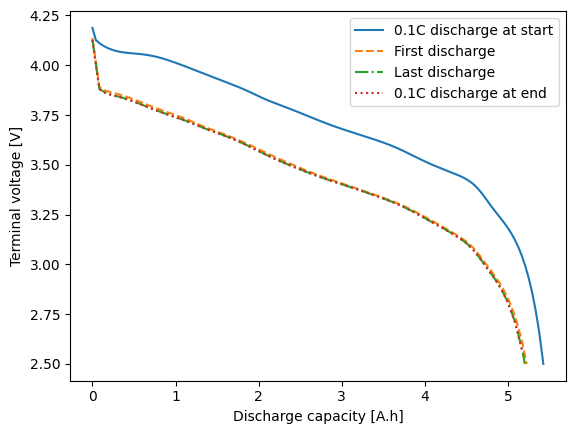

In [465]:
fig, ax = plt.subplots()
ax.plot(Qdis_zero,Vdis_zero,label="0.1C discharge at start")
ax.plot(Qdis_first,Vdis_first,label="First discharge",linestyle="dashed")
ax.plot(Qdis_last,Vdis_last,label="Last discharge",linestyle="dashdot")
ax.plot(Qdis_eval,Vdis_eval,label="0.1C discharge at end",linestyle="dotted")
ax.set_xlabel("Discharge capacity [A.h]")
ax.set_ylabel("Terminal voltage [V]")
ax.legend()
filename = path+"FullyCoupled_ZFLE.pdf"
plt.savefig(filename)
plt.show()